# Heat-Wave: Risk assessment

Based on the current climate scenario the occurrence of the heat-wave phenomenon should be more frequent in the future in Europe. The main problems connected with Heat-wave events are the overheating of the urban areas, which lowers the comfort of living or causes health issues[[Integrated Assessment of Urban Overheating Impacts on Human Life](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022EF002682)], drought, and water scarcity. Nowadays, there are a lot of studies and methodologies on how we can mitigate the influence of these events. This toolbox wants to answer simple questions that are more frequently asked by crisis management local authorities, urban planners, or policymakers. 

 - These questions are:
   1. What are the problematic areas? (most overheated areas)
   2. Who or What is exposed?

## Step 1: Import packages

In [3]:
import zipfile        # working with the zip folders #
import os             # handling the current working directory
import rasterio       # netcdf and raster processing  #
from pathlib import Path # file system paths
import rioxarray as rxr # netcdf and raster processing
import rioxarray
import cdsapi         # API downloading
import numpy as np    # 2-3D array data handling
import pandas as pd   # data handling #
import xarray as xr   # 2-3D array data handling 
import cartopy.crs as ccrs # netcdf data projection 
import cartopy.feature as cf # netcdf data projection 
import cartopy.crs as ccrs # netcdf data projection 
import matplotlib as mpl  #  data plot #
import matplotlib.pyplot as plt #  data plot #
from rasterio.crs import CRS  #  raster dat handling 
from pylab import pcolormesh,show,colorbar,plot,title,legend,subplot,savefig
from xrspatial.classify import reclassify
from matplotlib import pyplot
from rasterio.plot import show
from glob import glob
import geopandas as gpd
import rasterio as rio
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from ipyleaflet import Map, DrawControl, Marker, LayersControl, LegendControl, GeoData, GeoJSON, WidgetControl
import ipywidgets as widgets
import leafmap.leafmap as leafmap
from localtileserver import get_leaflet_tile_layer, TileClient
from itertools import chain
import copy
from datetime import datetime, timedelta
from localtileserver import get_leaflet_tile_layer, TileClient
import json
import random
import requests
import rasterstats
import plotly.express as px

## Step 2: Create a directory structure

In [4]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'Heat_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))

## Step 3: Set your CDS API key 

- You can download a data from the CDS with the API - look at [[How to change your API KEY](https://cds.climate.copernicus.eu/api-how-to)] and change the KEY

In [ ]:
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "!!!!!!!!!!Put your KEY!!!!!!!!!!!!!!!!" ### put here your key

## Step 4: Trends of the Heat-Days/Nights occurence change under the climate scenarios

- On the website Climate-adapt we can find the trends of the occurrence of the days with Extreme heat. The content in the European Climate Data Explorer pages is delivered by the Copernicus Climate Change Service (C3S) implemented by ECMWF. 
- We select the region of Slovakia where we can also find Zilina city, this is the estimation for the whole region NUTS2
- Our toolbox in the next steps will provide information from a closer perspective over the Zilina city and Europe.

**Heat days occurence in the past [[Source](https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days)]**

**Heat days occurence in the future [[Source](https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days)]**

**Tropical night past and projections [[Source](https://climate-adapt.eea.europa.eu/en/observatory/++aq++metadata/indicators/tropical-nights/)]**

## Step 5. Download Observed 2m air temperature over Europe 

- In this part of the notebook, we go to the smaller scale than NUTS2. These data give us information about the observed temperature over Europe. These data also help us find the periods with higher air temperatures for the selection of the Landsat8 images. 

In [ ]:
# This takes time!!!
c = cdsapi.Client(url=URL, key=KEY)

zip_path = os.path.join(data_dir, 'eobs_airtemp_2011_2023.zip')

c.retrieve(
    'insitu-gridded-observations-europe',
    {
        'product_type': 'ensemble_mean',
        'variable': 'maximum_temperature',
        'grid_resolution': '0.1deg',
        'period': '2011_2023',
        'version': '28.0e',
        'format': 'zip',
    },
   f"{data_dir}/eobs_airtemp_EU_2011_2023.zip")

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'eobs_airtemp_EU_2011_2023.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

## Step 6. Heat islands identification

### Data description

**Heat islands:**

Heat islands are urbanized areas that experience higher temperatures than outlying areas. Structures such as buildings, roads, and other infrastructure absorb and re-emit the sun’s heat more than natural landscapes such as forests and water bodies. Urban areas, where these structures are highly concentrated and greenery is limited, become “islands” of higher temperatures relative to outlying areas [[Heat islands](https://www.epa.gov/heatislands)]
For the identification of the heat islands from the historical data we can use these data:

Data needs to be manually downloaded from provided websites, it requires registration and manual choosing of your area and period (except Euro-Cordex):

**Historical data from satellite sensors:**

- Landsat8 land surface temperature (LST) for 2016-2020 (15-30m spatial; 8-16 days temporal). For the identification of the heat island, we can use this product, which provides the data about calculated land surface temperature from the Landsat8 imagery. The LST product is available on the RSLAB website or can be calculated from the L8 imagery bands.
Download:  ### [[RSLAB LST data download](https://rslab.gr/Landsat_LST.html)] (only for 2015-2021) ## recalculation of the LST from Landsat8 imagery [[Landsat8-9 raw images imagery](https://earth.esa.int/eogateway/catalog/landsat-8-collection-2-european-coverage)]


- Sentinel3 LST # [[manual](https://www.youtube.com/watch?v=GbQOZJC6Jgc)] # [[Data Download](https://dataspace.copernicus.eu/browser/?zoom=12&lat=49.178&lng=18.89992&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2Fa91f72b5-f393-4320-bc0f-990129bd9e63&datasetId=S2_L2A_CDAS )]

### Download the Landsat 8 land surface temperature

We can use LST for the summer months (June, July, August) when we can expect the overheating of the urban areas. Based on the LST we can easily identify the heat islands (Dark Red areas).

- for the best estimation of the overheated areas it is best to consult the selection of the days with local Meteorological authorities, they can provide the data about measured air temperature from the past. 
- or you can look at the observed ait temperature in [[CDS Observed temperature 12x12km](https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-gridded-observations-europe?tab=form)]

for [[Download of the precomputed LST](https://rslab.gr/Landsat_LST.html)] (for years 2013-2021) for [[Calculation of the LST](https://www.youtube.com/watch?v=hd7fscNTff4)] for [[Download of the precomputed LST](https://rslab.gr/Landsat_LST.html)] (for years 2013- till now)

**Before downloading the data create a new folder in the data_dir called LST, where you download data. Then you can proceed with this code.** 

- Download all available **[all available years for summer months June, July, August, in the south of the EU you also download a data form May and September]** LST imagery and save it to the created LST folder. You do not need to unzip a data, because you can do it automatically with the following code (below)
1. You can download the precomputed values from the RSlab web portal for years 2013-2021 # [[LST data download](https://rslab.gr/Landsat_LST.html)]
    - How to use the RSLAB:
    - (1.) Draw a polygon on the map by clicking (not dragging) on the map to select the vertices of the polygon.
    - (2.) Select your preferred Landsat source. Please check the availability for each Landsat above. It is recommended to use MODIS and NDVI-based emissivity for Urban/Peri-Urban areas and ASTER emissivity for Natural/Isolated areas. Refer to the paper for more details-
    - (3.) Select your preferred emissivity source. Please check the important notes above about emissivity. For more details on this subject please refer to the paper 
    - (4.) Click the "Calculate LST" button.
    - (5.) The results will be presented below the map. For each LST result you will find a "show" button that displays the LST as a layer on the map and calculates the mean/min/max LST value for the selected image.
    - (6.) For each LST result you will find a **"download"** button that downloads the LST as a .tiff image .to download all the images click the **"download all"** button at the end of the list. The downloaded .tiff is cut based on your polygon.
      
2. Or you can calculate the LST directly from the Landsat imagery # 
 [[Manual for computation](https://www.youtube.com/watch?v=hd7fscNTff4)].

-  Save data to your Heat_workflow folder /data_dir/LST.
-  Then you can continue with the following code.

In [ ]:
# This code unzips all downloaded LST data 
working_directory = os.path.join(data_dir, 'LST')
# Loop through all files in the directory
for file in os.listdir(working_directory):
    file_path = os.path.join(working_directory, file)
    # Check if the file is a zipfile
    if zipfile.is_zipfile(file_path):
        # Open the zipfile
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            # Extract all contents of the zipfile into the working directory
            zip_ref.extractall(working_directory)

In [17]:
from datetime import datetime
# This code extraxcts all dates from LST tif.files
# Create a list of file paths to your LST files using glob
L8list = glob(f"{data_dir}/LST/*LST*.tif")
# Initialize an empty list to store the datetime objects
lst_dates = []
# Loop through each filename
for file in L8list:
    # Extract the filename without the directory path
    filename = file.split('/')[-1]   
    # Extract the date and time part from the filename
    if "AllImages_LST" in filename:
        date_time_str = filename.split('.')[1]
        date_str = date_time_str.split('_')[0]
        time_str = date_time_str.split('_')[1]
    else:
        date_str = filename[4:12]  # Extract date part directly
        time_str = filename[13:19]  # Extract time part directly    
    # Combine date and time strings into a single string
    datetime_str = date_str + '_' + time_str    
    # Convert the combined datetime string to a datetime object
    datetime_obj = datetime.strptime(datetime_str, '%Y%m%d_%H%M%S')   
    # Append the datetime object to the lst_dates list
    lst_dates.append(datetime_obj)

In [17]:
# This code will create a raster stack from all downloaded data
# Load a data and crate a raster stack from all maps
L8list = glob(f"{data_dir}/LST/*LST*.tif")
#
with rasterio.open(L8list[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(L8list))
# Save a data to working directory
with rasterio.open(f'{data_dir}/L8_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(L8list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [19]:
# This code calculates mean values from the LST rasters which are not significantly influenced by clouds
# Open the raster stack
stack_path = f'{data_dir}/L8_raster_stack.tif'
raster_dataset = xr.open_dataset(stack_path)
# Count the number of pixels greater than 0 for each band
num_pixels_gt_zero = (raster_dataset > 0).sum(dim=('x', 'y'))
# Calculate the total number of pixels for each band
total_pixels = raster_dataset.sizes['x'] * raster_dataset.sizes['y']
# Calculate the proportion of pixels greater than 0
prop_gt_zero = num_pixels_gt_zero / total_pixels
# Filter bands where at least 70% of pixels are greater than 0
filtered_bands = raster_dataset.where(prop_gt_zero >= 0.5)
# Calculate the mean values for the filtered bands
mean_values_filtered = filtered_bands.mean(dim=('x', 'y'))
#mean_values_filtered = mean_values_filtered.fillna(0)
mean_values_filtered=mean_values_filtered['band_data']
mean_values_list = mean_values_filtered.values.tolist()

- This code plots all LST rasters that we downloaded, it is important to check it and relise how many pictures are influenced with the clouds=dark blue.

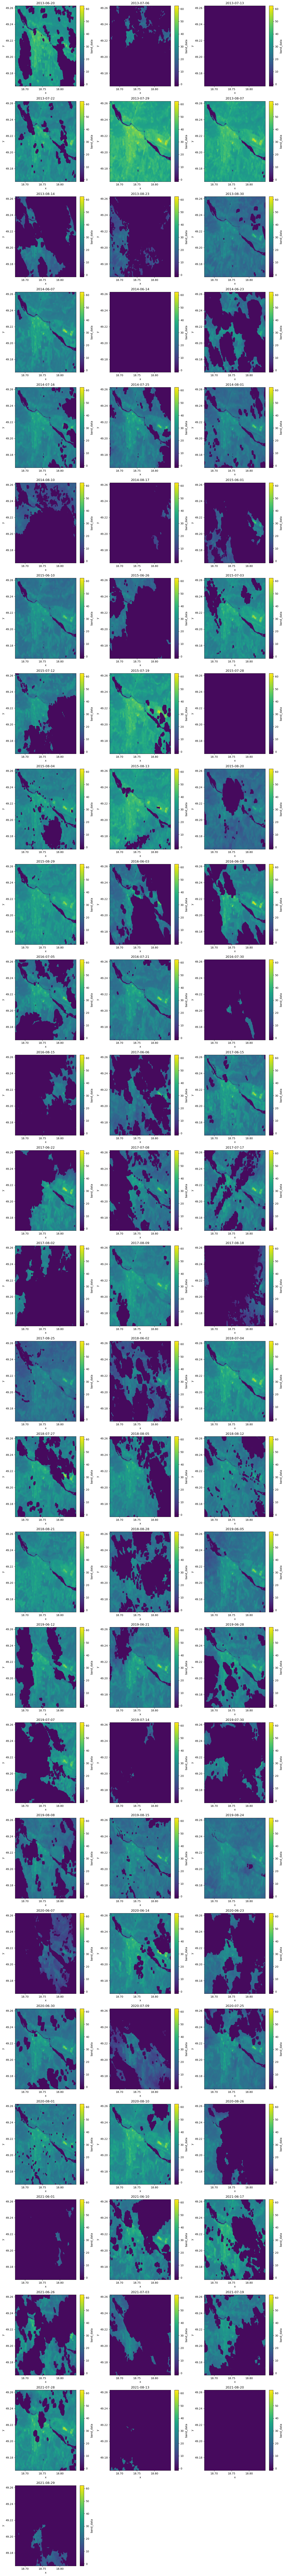

In [18]:
# This code plots all rasters from LST raster stack 
from datetime import datetime
# Define the path to your raster stack
stack_path = f'{data_dir}/L8_raster_stack.tif'
# Open the raster stack
raster_dataset = xr.open_dataset(stack_path)['band_data']
# Get the number of bands (rasters)
num_bands = raster_dataset.band.size
# Calculate the number of rows needed based on the number of bands and desired number of columns (3 in this case)
num_rows = (num_bands + 2) // 3  # Ceiling division to get the nearest whole number
# Create a Matplotlib figure and axes
fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
# Flatten the axes array if num_rows = 1
if num_rows == 1:
    axs = axs.reshape(1, -1)
# Initialize variables to store global max and min values
global_max = float('-inf')
global_min = float('inf')
# Loop through each band and find global max and min
for i in range(num_bands):
    band_data = raster_dataset.isel(band=i)
    global_max = max(global_max, band_data.max().values)
    global_min = min(global_min, band_data.min().values)
# Loop through each band again to plot
for i, ax in enumerate(axs.flat):
    if i < num_bands:
        # Plot the raster for the current band with the same color scale
        raster_dataset.isel(band=i).plot(ax=ax, vmin=global_min, vmax=global_max)        
        # Set the date as the title
        ax.set_title(lst_dates[i].strftime("%Y-%m-%d"))
    else:
        # Hide the empty subplot
        ax.axis('off')

plt.tight_layout()
plt.show()

### Reclasify of the maximum LST values based on the LST temperature


- In this step, you reclassify the LST into 6 categories based on the temperature
- You can change the treshold values for each category:
  
  1. **No overheat** - no data because of the water
  2. **Very low** < 20°C
  3. **Low** > 20°C
  4. **Medium** > 30°C
  5. **High** > 40°C
  6. **Very High** > 50°C
     
- We need to realize that these values represent the Surface temperature, not the air temperature. The surface temperature reaches higher values than air temperature. Ground surface temperature has become an important component of weather. The temperature of the ground surface can be more than 10 C above air temperature on a sunny day and up to 10 C below air temperature on clear nights, when the surface loses heat by radiation to the cold infinity of outer space. Like most environmental sensors, infrared sensors have become more accurate and lower cost over the past 10 years. [[Land surface temperature vs air temperature](https://caas.usu.edu/weather/graphical-data/surface-temperature)]

**Vegetation respond to high temperatures**
- **If you are more interested in the effect on vegetation**
- For most species, actively growing tissue is damaged by brief exposure to temperatures above 45°C, while prolonged exposure can result in fatal injury. Temperatures between 30-40°C can be termed moderately high temperatures and result in reversible inhibition of metabolism (moderate heat stress). Temperatures above 40°C can be termed very high temperatures as they result in irreversible or prolonged inhibition of metabolism (severe heat stress) [[source](https://www.rseco.org/content/1471-plant-response-high-temperature.html)]. Based on this we suggest the values:

  1. **No overheat** - no data because of the water
  2. **Very low** < 20°C
  3. **Low** > 20°C
  4. **Medium** > 30°C
  5. **High** > 40°C
  6. **Very High** > 45°C 

Text(0.5, 1.0, 'Overheated areas in Zilina city')

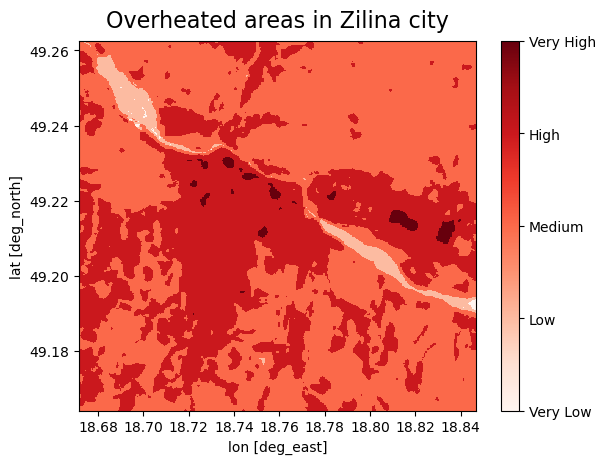

In [8]:
# This code calculates the maximum values from the raster stack of the LST and reclassifies the LST data into 5 groups based on the temperature
# Laod a data calculate maximum values from raster stack
L8 =f'{data_dir}/L8_raster_stack.tif'
L8 = xr.open_dataset(L8)
L8=L8.max(dim='band', skipna=True,  keep_attrs=True)
L8lst2016=L8['band_data']
lstbbox = L8.rio.bounds()
# Reclasiffy data to the groups by the temperature 
lc_bins=[20, 30, 40, 50, 100] ### Effect on the human health
#lc_bins=[0,20, 30, 40, 45, 100] ### Effect on the vegetation
lc_values=[1, 2, 3, 4, 5]
lc_class = reclassify(L8lst2016, bins=lc_bins, new_values=lc_values)
# Plot a data
fig, ax = plt.subplots()
oa = lc_class.plot(ax = ax, cmap='Reds', add_colorbar=False)
cbar = fig.colorbar(oa, ticks=[0, 1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(['No overheat', 'Very Low', 'Low', 'Medium', 'High', 'Very High'], size=10)
ax.set_xlabel('lon [deg_east]')
ax.set_ylabel('lat [deg_north]')
plt.title('Overheated areas in Zilina city', size=16, pad = 10)

### Save the LST map on disk

In [1]:
# Save data on disk
lc_class.rio.to_raster(raster_path=f'{results_dir}/LSTZA.tif')

NameError: name 'lc_class' is not defined

### Calculation of the Landsat LST from Landsat 8 - 9 imagery (only in case if you not use the RSLAB)

Calculation of the Landsat LST from Landsat 8 - 9 imagery
data are from european space agency.
For the data download you need to choose the level of the data L1 or L2.
L1 level contains all 11 bands
L2 level contains bands 1-7 and band 10
We need to download the L8-9: [[Manual](https://www.youtube.com/watch?v=Eug32jeK8Gw)], [[Data](https://earth.esa.int/eogateway/catalog/landsat-8-collection-2-european-coverage)], [[Process](https://www.youtube.com/watch?v=hd7fscNTff4)]

**You do not need to calculate you can download it from [[RSLAB](https://rslab.gr/Landsat_LST.html)] for years 2013-2021**

- but if you want to most recent data (2022-Now) you need to calculate it:

In [ ]:
# Radiance
rad=0.00033420 * b10 + 0.1

# Brightest temperature
bt=1321.0789/np.log(774.8853/rad + 1)-272.15

# Normalized difference vegetation index
ndvi=(b5-b4)/(b5+b4)
ndvi_min=ndvi.min(skipna=True)
ndvi_max=ndvi.max(skipna=True)

# Proportion of the Vegetation 
pv=((ndvi +  ndvi_min)/(ndvi_max+ndvi_min))**2

# Emisivity
emi=0.004*pv+0.986

# Land surface temperature
LST=(bt+1)+10.8*(bt/14380)*np.log(emi)

In [ ]:
# Radiance
rad=0.00033420 * b10 + 0.1

In [ ]:
# Brightest temperature
bt=1321.0789/np.log(774.8853/rad + 1)-272.15

In [ ]:
# Normalized difference vegetation index
ndvi=(b5-b4)/(b5+b4)
ndvi_min=ndvi.min(skipna=True)
ndvi_max=ndvi.max(skipna=True)

In [ ]:
# Proportion of the Vegetation 
pv=((ndvi +  ndvi_min)/(ndvi_max+ndvi_min))**2

In [ ]:
# emisivity
emi=0.004*pv+0.986

In [ ]:
# land surface temperature
LST=(bt+1)+10.8*(bt/14380)*np.log(emi)

## Step 7: Plot the observed maximum 2m air temperature together with LST temperature

- We display the measured data of the 2m air temperature together with the LST data, to see for which days we downloaded the LST data.
- This step will give us the information if we downloaded the data for the days with the highest air temperature. 

### Loads the observed temperature data

In [10]:
# This code crops the Observed temperature data to your selected BBox )lstbbox), and save a data to data_dir
# Read a data 
at = xr.open_mfdataset(f'{data_dir}/tx_*.nc', decode_coords='all') # to read a multiple datasets 
at.rio.write_crs("epsg:4326", inplace=True)
at=at['tx']
atEU=at
at_city=at.rio.clip_box(minx=lstbbox[0], miny=lstbbox[1], maxx=lstbbox[2], maxy=lstbbox[3])
# Delete the data from memory
# select a time window 
at_year=at_city.sel(time=slice("2013-04-01", "2023-06-30")) # Change the dates for specific year
at_year_m = at_year.mean(dim='time', skipna=True, keep_attrs=True)
at_year_m.rio.to_raster(raster_path=f'{data_dir}/at_m.tif')
at_year.rio.to_raster(raster_path=f'{data_dir}/at_y.tif')

### Plot the observed temperature data on map and select a point for plotting a graphs

In [11]:
# This code plots the map where we need to select the point for the plot of the graphs for computed indices
# First, create a tile server from local raster file
client1 = TileClient(f'{data_dir}/at_m.tif')
# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, cmap='Reds', opacity=0.5, nodata=0, name='Heat-wave index')
#m = Map(center=client1.center(), zoom=client1.default_zoom)
m = Map(center=client1.center(), zoom=9)
m.add(t1)
control = LayersControl(position='topright')
m.add_control(control)
# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []
# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            m.add_layer(marker)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

### Plot a data for selected point

In [40]:
at_year = xr.open_dataset(f'{data_dir}/at_y.tif') # to read a multiple datasets 
# This code extracts the data values for the selected pixel
lat = point_lat_list[0] 
lon = point_lon_list[0]
extracted_data = at_year.sel(y=lat, x=lon, method='nearest')
d=extracted_data['band_data']
air_temp = d.values.tolist()

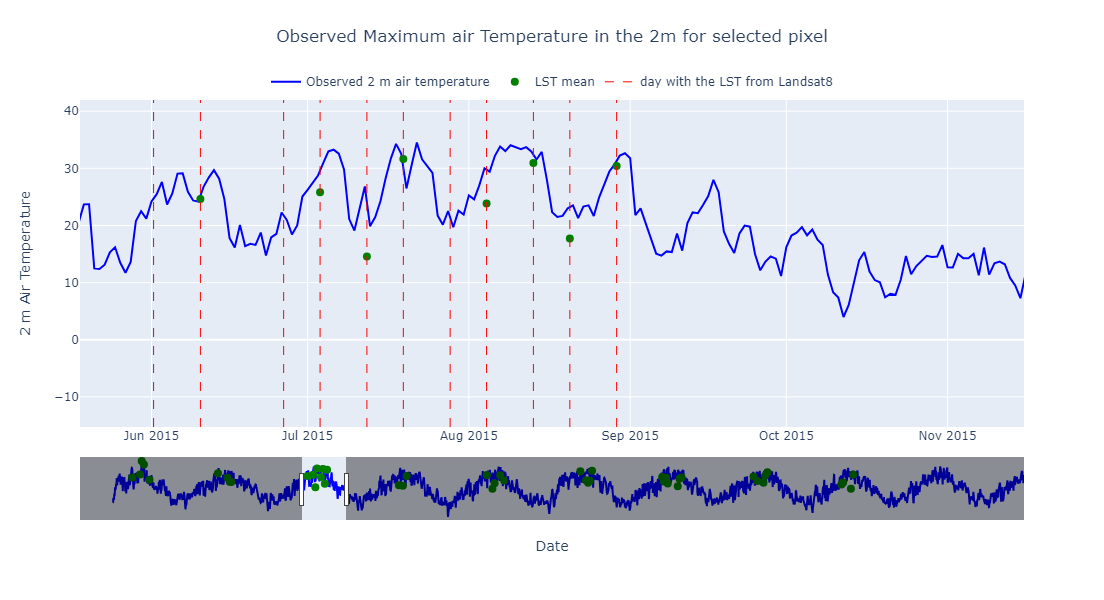

In [42]:
# Sample data
start_date = datetime(2013, 4, 1)
end_date = datetime(2023, 6, 30)
date_list = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]
values = air_temp  # Replace this with your actual data
# Create figure
fig = go.Figure()
# Add line trace with legend
fig.add_trace(go.Scatter(x=date_list, y=values, mode='lines', name='Observed 2 m air temperature', line=dict(color='blue'), showlegend=True))
fig.add_trace(go.Scatter(x=lst_dates, y=mean_values_list, mode='markers', name='LST mean', marker=dict(color='green', size=8), showlegend=True))
# Add title and axis labels
fig.update_layout(
     title={
        'text': "Observed Maximum air Temperature in the 2m for selected pixel",
        'x':0.5,
        'y':0.95,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Date",
    yaxis_title="2 m Air Temperature",
    width=1100,  # Width of the graph
    height=600,
    legend=dict(
        orientation="h",  # Set legend orientation to horizontal
        yanchor="top",  # Anchor legend to the top
        y=1.1,  # Adjust y position
        xanchor="center",  # Anchor legend to the center horizontally
        x=0.5  # Adjust x position
    )
)
# Add slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
# Add vertical lines for each date in date_list2
for date in lst_dates:
    fig.add_shape(
        type="line",
        xref="x",
        yref="paper",
        x0=date,
        y0=0,
        x1=date,
        y1=1,
        line=dict(color="red", width=1, dash="dash"),
        name='Highlighted Date'
    )
# Add custom legend item for vertical lines
fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='lines',
    line=dict(color='red', width=1, dash='dash'),
    name='day with the LST from Landsat8'
))
# Show plot
fig.show()

- When you take your Landsat8 LST data and look at the maximum observed 2m air temperature you will see if the LST temperature was reached during a heat wave or just during a hotter day.
- Vertical red dash line represents the times for which we found Landsat8 LST pictures. **You can zoom in / out in the picture with a slider.**
- The **green dots** represent the mean LST value for the LST image
- If we cannot detect a **green dot** on the red line, that means that the LST image has values for less than 50% of the pixels (due to clouds)
- The LST mean values for the LST images with cloud coverage lower than 50% will be plotted with the code below

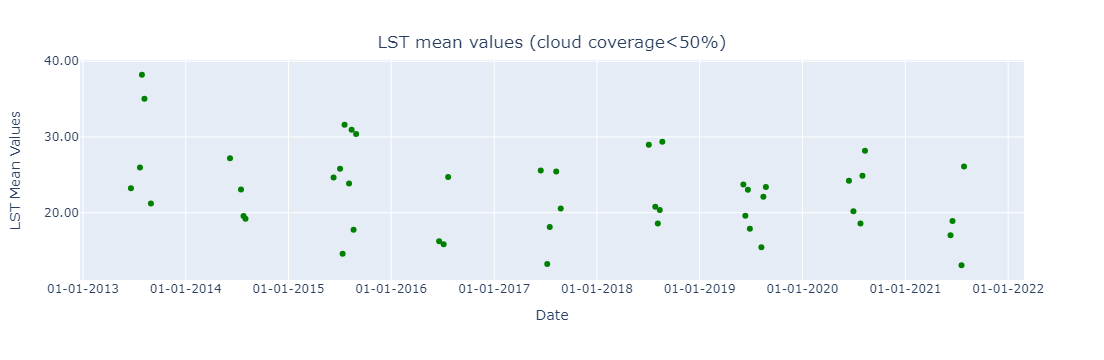

In [63]:
import datetime
# Create a dictionary from your data
data = {'Dates': lst_dates, 'Values': mean_values_list}
# Create a DataFrame from the dictionary
import pandas as pd
df = pd.DataFrame(data)
# Plot using Plotly Express
fig = px.scatter(df, x='Dates', y='Values', labels={'Dates': 'Date', 'Values': 'LST Mean Values'}, color='Values')
fig.update_traces(marker=dict(color='green'))  # Set dot color to green
fig.update_traces(mode='markers')  # Display as dots
# Add title and center it
fig.update_layout(title_text='LST mean values (cloud coverage<50%)',
                  title_x=0.5,  # Center the title horizontally
                  title_y=0.9)  # Adjust vertical position if needed
fig.update_xaxes(tickformat='%d-%m-%Y')
fig.show()

## Step 8: Identify vulnerable population groups 

- We can use the maps of the distribution of the population across the interested area and look if the most populated areas overlay with the most overheated parts. 

- For the Zilina pilot, we collected data from the Zilina municipality office about the buildings that are usually crowded with huge masses of people, e.g. hospitals, stadiums, main squares, big shopping centers, main roads, and bigger factories... **You can apply your data in this part**   

- If places like these are overheated, a huge number of people can be negatively influenced by the Heat. With that, the risk probability also rises, and thus, these areas are prioritized for Heat mitigation measures.  

### Download the Vulnerable population data 

 1. In the link [[Source](https://data.humdata.org/dataset/?dataseries_name=Data%20for%20Good%20at%20Meta%20-%20High%20Resolution%20Population%20Density%20Maps%20and%20Demographic%20Estimates&groups=esp&res_format=GeoTIFF&q=&sort=last_modified%20desc&ext_page_size=25)]:
       -  Select the **High Resolution Population Density Maps + Demographic Estimates**
       -  Select the **Location**
       -  Select the **Formats** to GeoTIFF.
  
 2. Download the maps for the most vulnerable groups of the population **elderly 60+ years and children under 5 years**. Save the data in the data_dir where you create a folder **population** and save it there.

 3. When you download all these maps to the Heat-workflow data folder you  can use this code for data handling:
    - in the first step we load all the maps of the critical population 
    - then we calculate the sum of the vulnerable population from each of the maps
    - we classified the maps into 5 groups (equal intervals)
    - plot it next to a map of overheated areas.

### Loads the vulnerable population data

In [7]:
# This code loads all population data and creates a raster stack from them 
poplist = glob( f'{data_dir}/population/*.tif')
#
with rasterio.open(poplist[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(poplist))
#
with rasterio.open(f'{data_dir}/Population_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(poplist, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

### Reclassify the vulnerable population data to 5 classes

- We need to reclassify the vulnerable population dtaa to 5 groups based on the density of the population. 

In [6]:
pop=f'{data_dir}/Population_raster_stack.tif'
pop = xr.open_dataset(pop)
pop=pop.sum(dim='band', skipna=True,  keep_attrs=True)
pop=pop['band_data']
pop=pop.rio.clip_box(minx=lstbbox[0], miny=lstbbox[1], maxx=lstbbox[2], maxy=lstbbox[3])
# Calculate the number of bins (classes)
num_bins = 4
# Equal interval classification
min_value = np.nanmin(pop)  # Minimum population value
max_value = np.nanmax(pop)  # Maximum population value
bin_width = (max_value - min_value) / num_bins  # Width of each bin
pop_bins = [min_value + i * bin_width for i in range(num_bins + 1)]  # Define bin boundaries
pop_values=[1, 2, 3, 4, 5]
pop_class = reclassify(pop, bins=pop_bins, new_values=pop_values)

### Plots the maps of the overheated areas with the vulnerable groups of population 

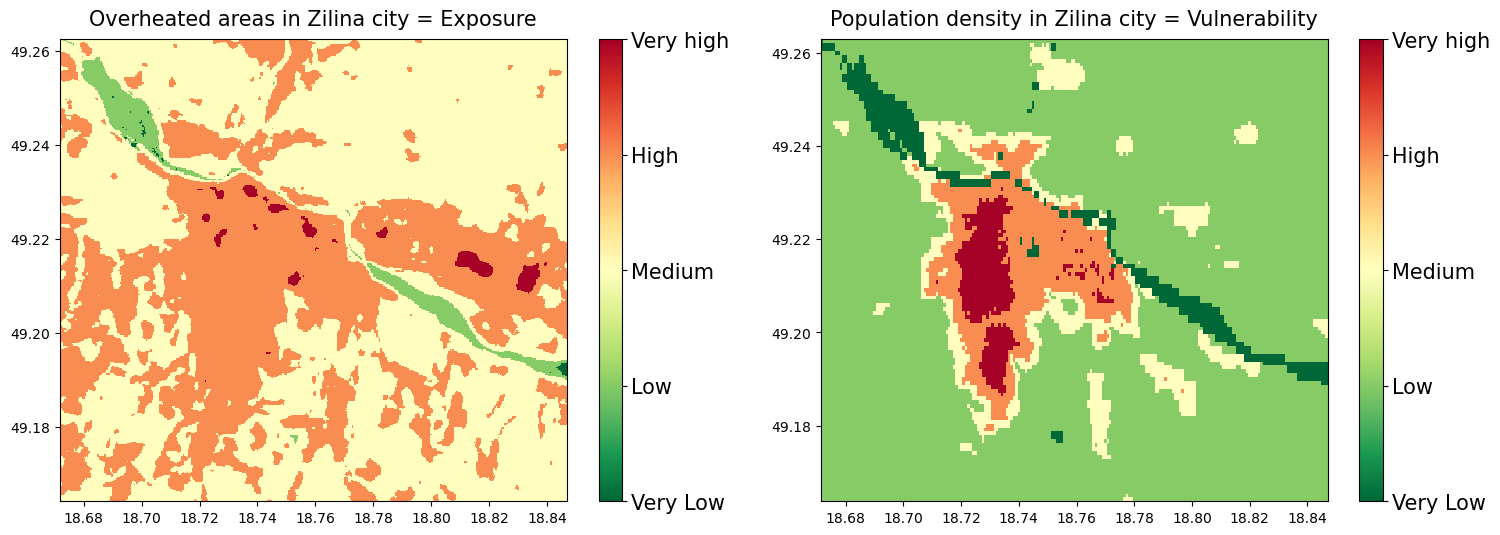

In [10]:
# This plots the Overheated areas and Population density maps
fig, axes=plt.subplots(ncols=2, figsize=(18,6))
# Plot a data
oa1 = lc_class.plot(ax = axes[0], cmap='RdYlGn_r', add_colorbar=False)
cbar = fig.colorbar(oa1, ticks=[ 1, 2, 3, 4, 5])
cbar.ax.set_yticklabels([ 'Very Low', 'Low', 'Medium', 'High', 'Very high'], size=15)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Overheated areas in Zilina city = Exposure', size=15, pad = 10)
# Plot a data
oa2 = pop_class.plot(ax = axes[1], cmap='RdYlGn_r', add_colorbar=False)
cbar = fig.colorbar(oa2, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_yticklabels([ 'Very Low', 'Low', 'Medium', 'High', 'Very high'], size=15)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('Population density in Zilina city = Vulnerability', size=15, pad = 10)
plt.draw()

- On this plots we can see the most overheated areas togehter with the population density of the vulnerable groups of population
- These maps were reclassified to the 5 groups, for the computation of the final Risk map based on the 5x5 risk matrix 

![Heat-wave ilustration](https://github.com/CLIMAAX/HEATWAVES/blob/main/Images/risk_matrix.png?raw=true "Risk matrix example")

### Save data LST and population map

In [16]:
# This code saves the data to results_dir
lc_class.rio.to_raster(raster_path=f'{results_dir}/risk_LST.tif')
pop_class.rio.to_raster(raster_path=f'{results_dir}/risk_pop.tif')

## Step 9: Calculate the heat-wave risk map 

- In this step we calculate the heat-wave **Risk** map based on the **Exposure (LST - most exposed areas to Heat)** x **Vulnerability (Vulnerable population)**
- **Risk = Exposure x Vulnerability**
- We need to also consider the **Probability** of the heat-occurrence under the climate scenarios. We can use the results of the heat-wave hazard assessment. However, because of the coarse resolution of the hazard data, we cannot implement it directly into the Risk equation. 

### Load a data and create a raster stack

In [17]:
# This code creates a raster stack from risk_LST and risk_pop data, we need this step for the next processing of the data 
S2list = glob( f'{results_dir}/risk_*.tif')
#
with rasterio.open(S2list[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(S2list))
#
with rasterio.open(f'{results_dir}/risk_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(S2list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

### Calculate the risk 

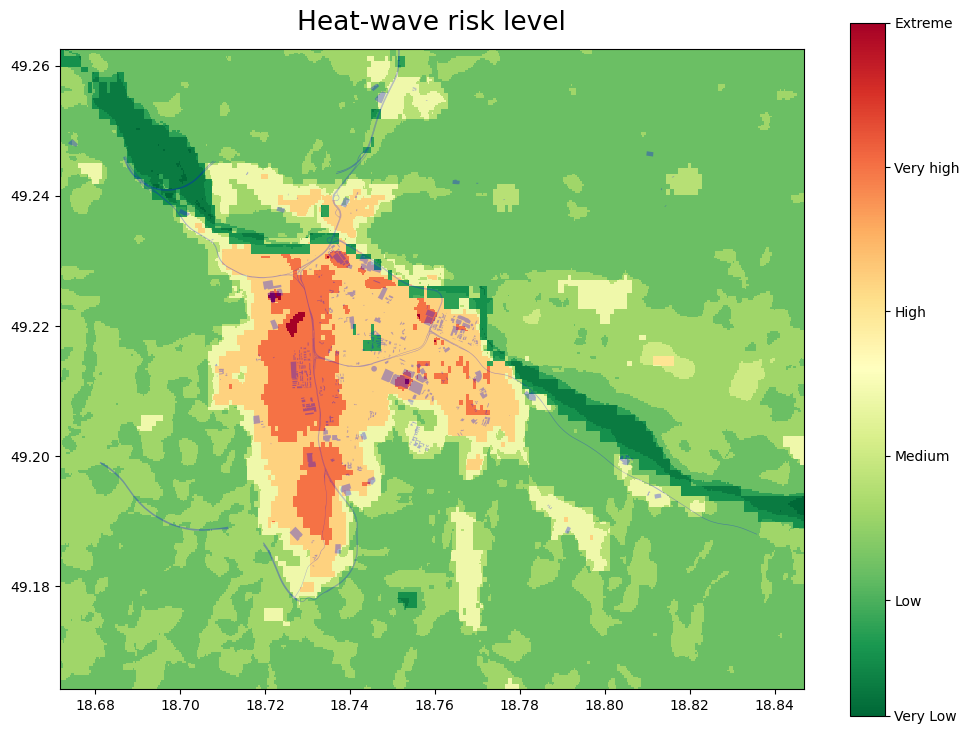

In [12]:
# This code calculates a risk map by multiplying a risk_LST and risk_pop data 
risk=f'{results_dir}/risk_raster_stack.tif'
risk = xr.open_dataset(risk)
risk=risk['band_data']
risk=(risk[0])*(risk[1])
# Plot a data
fig, ax = plt.subplots(figsize=(12, 9))

oa3 = risk.plot(ax = ax, cmap='RdYlGn_r', add_colorbar=False)
cbar = fig.colorbar(oa3, ticks=[1, 5, 10, 15, 20, 25])
cbar.ax.set_yticklabels([ 'Very Low', 'Low', 'Medium', 'High', 'Very high', 'Extreme'], size=10)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('Heat-wave risk level', size=19, pad = 14)

ci= CI_WGS.plot(ax=ax, color='blue', alpha=0.3)

### Save the risk map 

In [ ]:
# This code saves the risk identification map in the results_dir
risk2.rio.to_raster(raster_path=f'{results_dir}/Heatwave_risk_identificationZA.tif')

- Based on the risk interpretation map (above), we can identify the places most influenced by the Heat-waves (dark red), for better visualization we can load a map with leafmap (below).

### Step 10: Plot Risk data on the interactive map

- **To see these maps on the interactive zoom in/out map with the Open Street Base map run the code bellow**

In [3]:
# This code loads the Critical infrastructure map and covert it to EPSG:4326 crs, and saves it as Geojson
ci1 = gpd.read_file(f'{data_dir}/ci_features_ZA.shp', encoding='utf-8')
ci = ci1.to_crs(epsg=4326)
crs = ci.crs
#print("CRS of GeoJSON file:", crs)
ci.to_file(f'{data_dir}/ciZA4326.geojson', driver='GeoJSON')

In [4]:
# This code creates a tile client from risk maps
# First, create a tile server from local raster file
riskpop = TileClient(f'{results_dir}/risk_pop.tif')
riskLST = TileClient(f'{results_dir}/risk_LST.tif')
HWRI = TileClient(f'{results_dir}/Heatwave_risk_identificationZA.tif')

In [5]:
# This code creates ipyleaflet tile layer from that server
tpop = get_leaflet_tile_layer(riskpop, cmap='Reds',opacity=0.7, nodata=0, name='Risk population')
tLST = get_leaflet_tile_layer(riskLST, cmap='bwr',opacity=0.7, nodata=0, name='LST')
tHWRI = get_leaflet_tile_layer(HWRI, cmap='RdYlGn_r',opacity=0.7, nodata=0, name='Heat wave risk identification')

In [6]:
# This code loads the geojson Critical infrastructure map
with open(f'{data_dir}/ciZA4326.geojson', encoding='utf-8') as f1:
    geojson1 = json.load(f1)
geo_json1 = GeoJSON(data=geojson1, 
                    style={'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.3, 'weight': 1},
                    name = 'Critical infrastructure for Zilina city')

In [7]:
# This code loads the geojson Critical infrastructure map
with open(f'{data_dir}/ciZA4326.geojson', encoding='utf-8') as f1:
    geojson1 = json.load(f1)
geo_json1 = GeoJSON(data=geojson1, 
                    style={'opacity': 1, 'fillOpacity': 0.3, 'weight': 1},
                    name = 'Critical infrastructure for Zilina city')

In [8]:
# This code plots all loades rasters and vectors on the ipyleaflet map
m = Map(center=riskLST.center(), zoom=riskLST.default_zoom)

control = LayersControl(position='topright')

m.add(tpop)
m.add(tLST)
m.add(tHWRI)

labels = ["Very low", "Low", "Medium", "Very high", "Extreme"]
colors = [(0, 104, 55), (35, 132, 67), (255, 255, 191), (255, 127, 0), (215, 25, 28)]

# Create legend HTML content with custom styles (smaller size)
legend_html = "<div style='position: absolute; bottom: 2px; left: 2px; padding: 10px; " \
              "background-color: #FFF; border-radius: 10px; box-shadow: 2px 2px 2px rgba(0,0,0,0.5); " \
              "width: 75px; height: 205px; '>"

# Append legend items (labels with colored markers)
for label, color in zip(labels, colors):
    color_hex = '#%02x%02x%02x' % color  # Convert RGB tuple to hex color
    legend_html += f"<p style='font-family: Arial, sans-serif; font-size: 14px; '>" \
                   f"<i style='background: {color_hex}; width: 10px; height: 10px; display: inline-block;'></i> {label}</p>"

legend_html += "</div>"


# Create a custom widget with the legend HTML
legend_widget = widgets.HTML(value=legend_html)

legend_control = WidgetControl(widget=legend_widget, position='bottomleft')
m.add_control(legend_control)

m.add(control)
m.add(geo_json1)

m

Map(center=[49.2125405, 18.734994], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

### Conclusion

- You can add or remove a map by "click" on the "layer control" in the top right corner, or "Zoom in/out" by "click" on the [+]/[-] in the top left corner 
- **We recommend first unclicking all the maps and then displaying them one by one, the transparency of the maps allows you to see which areas on the OpenStreetMap are most exposed to the heat, and in combination with the distribution of the vulnerable population, you can easily identify which areas should be prioritized for the application of the heat mitigation measures.** 

## Step 11: Conslusion for the Risk identification results

- The results of the Risk workflow help you identify the places that are the most exposed to the effect of heat and also places populated with the vulnerable groups of populations in terms of heat.
- Together with the results of the Hazard assessment workflow that gives you the information about the probability of the heat-wave occurrence in the future, gives you a picture of the heat-wave connected problems in your selected area.
- However, we need to also consider the limitations of the data used for this analysis:
  - The Land surface temperature data derived from the Landsat 8 satellite imagery, do not provide data in daily steps. That means we get limited information on the maximum LST (because there is a possibility of the hotter days without an LST image from Landsat8). The resolution of the 30x30m also has a limitation, especially in the densely built-up areas.
  - The world population data were prepared for the year 2020, and there can be a change to the current day.
  - For this workflow, it will be best to prepare your vulnerable population (places) data with your local authorities. 

## Step 12: Calculate the vegetation characteristic NDVI

1. With NDVI you can detect a change in the plant's health e.g. before and after heat-wave
2. You can detect the areas with a lack of greenery
3. You can see the effect of the greenery on heat-islands
   
- In the simplest terms possible, the Normalized Difference Vegetation Index (NDVI) measures the greenness and the density of the vegetation captured in a satellite image. Healthy vegetation has a very characteristic spectral reflectance curve which we can benefit from by calculating the difference between two bands – visible red and near-infrared. NDVI is that difference expressed as a number – ranging from -1 to 1.
- Normalized Difference Vegetation Index: Change Detection
NDVI of a crop or a plant calculated regularly over periods of time can reveal a lot about the changes in their conditions. In other words, we can use NDVI to estimate plant health remotely.

- A sudden drop in the NDVI values may be a symptom of crop health deterioration.
The value drop can also correspond to normal changes, such as the time of harvesting, which is why NDVI should be counter-checked against other available data. Correct NDVI values interpretation can help agronomists raise healthier yields, save money on fertilizers, and take a better care of the environment. [[Source](https://www.cropin.com/blogs/ndvi-normalized-difference-vegetation-index)]

![![Heat-wave ilustration](https://github.com/CLIMAAX/HEATWAVES/blob/main/Images/ndvi_categories_example.png?raw=true "NDVI categories")

### Download of the NDVI or Sentinel 2 imagery [[download](https://browser.dataspace.copernicus.eu/?zoom=15&lat=49.19843&lng=18.72718&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2Fa91f72b5-f393-4320-bc0f-990129bd9e63&datasetId=S2_L2A_CDAS&fromTime=2019-08-31T00%3A00%3A00.000Z&toTime=2019-08-31T23%3A59%3A59.999Z&layerId=1_TRUE_COLOR)]
1. Register to the Copernicus browser website
2. Open the Copernicus browser [[copernicus browser](https://browser.dataspace.copernicus.eu/?zoom=15&lat=49.19843&lng=18.72718&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2Fa91f72b5-f393-4320-bc0f-990129bd9e63&datasetId=S2_L2A_CDAS&fromTime=2019-08-31T00%3A00%3A00.000Z&toTime=2019-08-31T23%3A59%3A59.999Z&layerId=1_TRUE_COLOR)]
3. Zoom to your area
4. Select: a Date -> cloud coverage to 10% -> select Sentinel-2 L2A
5. From LAYERS: display NDVI
6. Select a download from the panel on the right
7. Select: Analytical -> Image format: Tiff 32bit -> Image resolution: Custom (10x10m) -> Coordinate system: WGS84 -> Layers: B04, B08 (**do not download NDVI directly!!!**) -> Download to your data_dir (**and unzip it there**)
8. **Download NDVI for a multiple years during the vegetation period in your country, to see a vegetation conditions**

### Calculate the NDVI 

In [ ]:
# This code loads all Sentinel2 bands and calculate the NDVI 
from glob import glob
B4aug = glob(f"{data_dir}/*B04*.TIFF")
B8aug = glob(f"{data_dir}/*B08*.TIFF")
## JULY
for i in range(len(B4aug)):
    B4p=B4aug[i]
    B8p=B8aug[i]
    B4=xr.open_dataset(B4p)
    B4=B4['band_data']
    B8=xr.open_dataset(B8p)
    B8=B8['band_data']
    NDVI=(B8-B4)/(B8+B4)
    #NDVI84=NDVI.rio.reproject_match(L8lst2016)
    target_crs = 'EPSG:4326'  # WGS84
    NDVI = NDVI.rio.reproject(target_crs)
    #ndvi=NDVI.rio.clip_box(minx=18.67, miny=49.175, maxx=18.8, maxy=49.250)
    p=Path(B4aug[i])
    # https://peps.python.org/pep-0428/
    x=str(p.stem)
    parts = x.split('_')
    c=parts[0]
    e=c.replace('-', '_')
    ndvi.rio.to_raster(raster_path=f'{data_dir}/ndvi_'+ e +'.tif') 


In [ ]:
# Creates a raster stack from NDVI
# Corrected file path in glob to correctly format the year in the path
L8list = glob(f'{data_dir}/ndvi_*.tif')

if L8list:  # Check if the list is not empty
    with rasterio.open(L8list[0]) as src0:
        meta = src0.meta
        meta.update(count=len(L8list))  # Update metadata to reflect the number of layers

    # Updated file path and name formatting
    with rasterio.open(f'{results_dir}/ndvi_raster_stack.tif', 'w', **meta) as dst:
        for id, layer in enumerate(L8list, start=1):
             with rasterio.open(layer) as src1:
                 dst.write_band(id, src1.read(1))

### Reclasiffy the NDVI into groups

In [ ]:
# This code reclassifies the NDVI values to 4 classes based on the picture above
# Open the NDVI dataset
B4aug = glob(f"{data_dir}/*B04*.TIFF")
ndvi = xr.open_dataset(f'{results_dir}/ndvi_raster_stack.tif')
nd = ndvi['band_data']
# Define the bins and values for NDVI classification
ndvi_bins = [-1, 0, 0.3, 0.6, 1]  # These thresholds were based on the NDVI characteristics
ndvi_values = [0, 1, 2, 3, 4]
# Iterate over the years from 2016 to 2021
for i in range(len(B4aug)):
    p=Path(B4aug[i])
    x=str(p.stem)
    parts = x.split('_')
    c=parts[0]
    e=c.replace('-', '_')
    nd_year = nd[i]   
    # Reclassify the NDVI data
    ndvi_class = reclassify(nd_year, bins=ndvi_bins, new_values=ndvi_values)   
    # Save the reclassified NDVI data to a raster file
    ndvi_class.rio.to_raster(raster_path=f'{results_dir}/ndvi_reclass_plants_{e}.tif')

### Plot the NDVI on the interactive map

In [ ]:
# This code plots the NDVI on the map
import os
import glob
import rasterio
import folium
import numpy as np
import matplotlib.pyplot as plt
from folium.raster_layers import ImageOverlay
from folium import LayerControl
from branca.colormap import linear
# Initialize the Folium map
m = folium.Map(location=[49, 18], zoom_start=5)
# Assuming results_dir is where your raster files are
# results_dir = '/path/to/your/data'  # Update with your data directory
# Find min and max for NDVI files
ndvi_files = glob.glob(os.path.join(results_dir, '*reclass_plants*'))
ndvi_min, ndvi_max = float('inf'), float('-inf')
for raster_file in ndvi_files:
    with rasterio.open(raster_file) as src:
        data = src.read(1, masked=True)
        ndvi_min = min(ndvi_min, np.nanmin(data))
        ndvi_max = max(ndvi_max, np.nanmax(data))
# Process and add each NDVI raster file to the map
for raster_file in ndvi_files:
    with rasterio.open(raster_file) as src:
        data = src.read(1, masked=True)
        normalized_data = ((data - ndvi_min) / (ndvi_max - ndvi_min) * 255).astype('uint8')
        colormap = plt.get_cmap('Greens')
        mapped_colors = colormap(normalized_data / 255)
        mapped_colors = (mapped_colors[:, :, :3] * 255).astype('uint8')
        bounds = [
            [src.bounds.bottom, src.bounds.left],
            [src.bounds.top, src.bounds.right]
        ]
        img_overlay = ImageOverlay(
            image=mapped_colors,
            bounds=bounds,
            opacity=0.7,
            interactive=True,
            cross_origin=False,
            zindex=1,
            name=os.path.basename(raster_file)
        )
        img_overlay.add_to(m)
# Add a color scale for NDVI
ndvi_color_scale = linear.Greens_09.scale(ndvi_min, ndvi_max)
ndvi_color_scale.caption = 'NDVI Scale'
ndvi_color_scale.add_to(m)
# Add layer control
LayerControl().add_to(m)
# Display the map
m

### Heat-effect on plants

Plants respond to high temperatures
For most species, actively growing tissue is damaged by brief exposure to temperatures above 45°C, while prolonged exposure can result in fatal injury. Temperatures between 30-40°C can be termed moderately high temperatures and result in reversible inhibition of metabolism (moderate heat stress). Temperatures above 40°C can be termed very high temperatures as they result in irreversible or prolonged inhibition of metabolism (severe heat stress).[[source](https://www.rseco.org/content/1471-plant-response-high-temperature.html)])